# Episodeic Semi Gradient n-step SARSA

## Tilecoding as function approximation

In [3]:
basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)

    def fullp (self):
        return len(self.dictionary) >= self.size

    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if isinstance(m, IHT): return m.getindex(tuple(coordinates), readonly)
    if isinstance(m, int): return basehash(tuple(coordinates)) % m
    if m is None: return coordinates

from math import floor, log
from six.moves import zip_longest

def tiles(ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
VELOCITY_BOUND = [-0.07, 0.07]
POSITION_BOUND = [-1.2, 0.5]
ACTIONS = [-1, 0, 1]

In [6]:
class ValueFunction:

    def __init__(self, stepSize, numOfTilings=8, maxSize=2048):
        self.maxSize = maxSize
        self.numOfTilings = numOfTilings

        # divide step size equally to each tiling, Step size is interpreted as the fraction of the way we want to move towards the target. 
        # To compute the learning rate, scale by number of tilings. 
        self.stepSize = stepSize / numOfTilings 

        # Initialize index hash table (IHT) for tile coding.
        # This assigns a unique index to each tile up to max_size tiles.
        # Ensure max_size >= total number of tiles (num_tilings x tiling_dim x tiling_dim) to ensure no duplicates
        self.hashTable = IHT(maxSize)

        # Initialize weight for each tile
        self.weights = np.zeros(maxSize)

        # Tilecoding software partitions at integer boundaries, so must rescale position and velocity space to span tiling_dim x tiling_dim region.
        # position and velocity needs scaling to satisfy the tile software
        self.positionScale = self.numOfTilings / (POSITION_BOUND[1] - POSITION_BOUND[0])
        self.velocityScale = self.numOfTilings / (VELOCITY_BOUND[1] - VELOCITY_BOUND[0])




    # get indices of active tiles for given state and action 
    def getActiveTiles(self, position, velocity, action):
        activeTiles = tiles(self.hashTable, self.numOfTilings,
                            [self.positionScale * position, self.velocityScale * velocity],
                            [action])
        return activeTiles




    # estimate the value of given state and action, returns the value of current state, and action. When the agent reaches the goal state, returns 0.
    def value(self, position, velocity, action):
        if position == POSITION_BOUND[1]:
            return 0.0
        activeTiles = self.getActiveTiles(position, velocity, action)
        return np.sum(self.weights[activeTiles])




    # learn with given state, action and target - update weights based on the new estimation
    # The idea is that at each update time τ , the accumulated value up to τ+n is used to correct current estimation, 
    # and according to gradient descent idea, the parameter weight w is updated slightly towards the actual value proportionally to its derivative and delta.
    def update(self, position, velocity, action, target):
        activeTiles = self.getActiveTiles(position, velocity, action)
        estimation = np.sum(self.weights[activeTiles]) #linear FA
        delta = self.stepSize * (target - estimation)
        for activeTile in activeTiles:
            self.weights[activeTile] += delta



    # used for visualisation, returns the most negative value of that state and action(as the reward is always -1, the result is given a - sign).
    def costToGo(self, position, velocity):
        costs = []
        for action in ACTIONS:
            costs.append(self.value(position, velocity, action))
        return -np.max(costs)



In [7]:
class MountainCar:

    def __init__(self, n=1, exp_rate=0.1, gamma=1, debug=True):
        self.actions = [-1, 0, 1]  # reverse, 0 and forward throttle
        self.state = (-0.5, 0)  # position, velocity
        self.exp_rate = exp_rate
        self.gamma = gamma
        self.end = False
        self.n = n  # step of learning
        self.debug = debug
        # self.reset()

    def reset(self):
        pos = np.random.uniform(-0.6, -0.4)
        self.end = False
        self.state = (pos, 0)


    # takes in an action and determines next state of the car.
    def takeAction(self, action):
        pos, vel = self.state

        vel_new = vel + 0.001 * action - 0.0025 * np.cos(3 * pos)
        vel_new = min(max(vel_new, VELOCITY_BOUND[0]), VELOCITY_BOUND[1])

        pos_new = pos + vel_new
        pos_new = min(max(pos_new, POSITION_BOUND[0]), POSITION_BOUND[1])

        if pos_new == POSITION_BOUND[0]:
            # reach leftmost, set speed to 0
            vel_new = 0
        self.state = (pos_new, vel_new)
        return self.state


    # uses ϵ-greedy method, and in the greedy part, it chooses the action results in the most estimate value, giving by the valueFunc 
    def chooseAction(self, valueFunc):
        # choose an action based on the current state,
        if np.random.uniform(0, 1) <= self.exp_rate:
            # random action
            return np.random.choice(self.actions)
        else:
            # greedy action
            values = {}
            for a in self.actions:
                pos, vel = self.state
                value = valueFunc.value(pos, vel, a)
                values[a] = value
            return np.random.choice([k for k, v in values.items() if v == max(values.values())])

    def giveReward(self):
        pos, _ = self.state
        if pos == POSITION_BOUND[1]:
            self.end = True
            return 0
        return -1

    def play(self, valueFunction, rounds=1):
        for rnd in range(1, rounds + 1):
            self.reset()
            t = 0
            T = np.inf
            action = self.chooseAction(valueFunction)

            actions = [action]
            states = [self.state]
            rewards = [-1]

            while True:
                if t < T:
                    state = self.takeAction(action)
                    reward = self.giveReward()

                    states.append(state)
                    rewards.append(reward)

                    if self.end:
                        if self.debug and rnd % 500 == 0:
                            print(f"Round {rnd}: End at state {state} | number of states: {len(states)}")

                        T = t + 1
                    else:
                        action = self.chooseAction(valueFunction)
                        actions.append(action)
            
                tau = t - self.n + 1
                
                if tau >= 0:
                    G = 0
                    for i in range(tau + 1, min(tau + self.n + 1, T + 1)):
                        G += np.power(self.gamma, i - tau - 1) * rewards[i]

                    if tau + self.n < T:
                        state = states[tau + self.n]
                        G += np.power(self.gamma, self.n) * \
                            valueFunction.value(state[0], state[1], actions[tau + self.n])
                    
                    state = states[tau]
                    valueFunction.update(state[0], state[1], actions[tau], G)

                if tau == T - 1:
                    break

                t += 1

Round 500: End at state (0.5, 0.03269687377548047) | number of states: 154
Round 1000: End at state (0.5, 0.01853887469199737) | number of states: 117
Round 1500: End at state (0.5, 0.030109650572354592) | number of states: 153
Round 2000: End at state (0.5, 0.024857724276740656) | number of states: 121
Round 2500: End at state (0.5, 0.024415716055183154) | number of states: 162
Round 3000: End at state (0.5, 0.024090710487645065) | number of states: 150
Round 3500: End at state (0.5, 0.03385650855844087) | number of states: 171
Round 4000: End at state (0.5, 0.020394583531519867) | number of states: 120
Round 4500: End at state (0.5, 0.023660803596739218) | number of states: 111
Round 5000: End at state (0.5, 0.03239124005563569) | number of states: 169
Round 5500: End at state (0.5, 0.029600542647036186) | number of states: 160
Round 6000: End at state (0.5, 0.02318278548664921) | number of states: 121
Round 6500: End at state (0.5, 0.019867540294545072) | number of states: 113
Round

Text(0.5, 0, 'Cost to go')

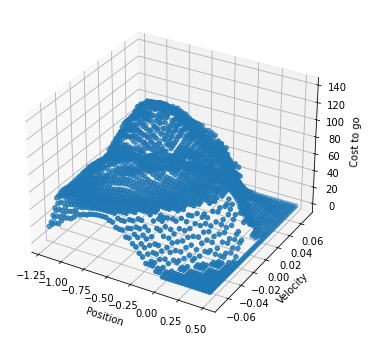

In [8]:
stepSize = 0.3
valueFunc = ValueFunction(stepSize)
mc = MountainCar()
mc.play(valueFunc, rounds=9000)


# visualisation: uses the costToGo function defined inside theValueFunction to measure the cost to reach the goal given a state and action
grids = 50

positions = np.linspace(POSITION_BOUND[0], POSITION_BOUND[1], grids)
vels = np.linspace(VELOCITY_BOUND[0], VELOCITY_BOUND[1], grids)

x = []
y = []
z = []
for p in positions:
    for v in vels:
        x.append(p)
        y.append(v)
        z.append(valueFunc.costToGo(p, v))

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel("Position")
ax.set_ylabel("Velocity")
ax.set_zlabel("Cost to go")